In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
% cd /content/drive/MyDrive/MIPT/ocr/course_ocr/task3

In [ ]:
! pip install -e .
! pip install wandb
! pip install pytorch-lightning
! pip install opencv-python
! pip install opencv-contrib-python

In [5]:
from course_ocr_t3.evaluate import read_file, calculate_detection_result, calculate_accuracy

import os
import yaml
import json
import math
import subprocess
from subprocess import TimeoutExpired
from collections import OrderedDict
from time import time
from pathlib import Path

import cv2
import imutils
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from itertools import product

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

import torchvision
import torchvision.utils as vutils
from torchvision import transforms as VT

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import pytorch_lightning as pl
import wandb
wandb.login()

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


## Data preparation

In [57]:
TRAIN_PATH = '/content/drive/MyDrive/MIPT/ocr/course_ocr/task3/data/train/Images'
train_filenames = os.listdir(TRAIN_PATH)
train_filenames = list(map(lambda x: os.path.join(TRAIN_PATH, x), train_filenames))

markup_train = read_file(os.path.join('/content/drive/MyDrive/MIPT/ocr/course_ocr/task3/', 'markup_train.csv'))

In [7]:
TEST_PATH = '/content/drive/MyDrive/MIPT/ocr/course_ocr/task3/data/test'
test_filenames = os.listdir(TEST_PATH)
test_filenames = list(map(lambda x: os.path.join(TEST_PATH, x), test_filenames))

markup_test = read_file(os.path.join('/content/drive/MyDrive/MIPT/ocr/course_ocr/task3/', 'markup.csv'))
markup_ans = read_file(os.path.join('/content/drive/MyDrive/MIPT/ocr/course_ocr/task3/', 'answer.csv'))

In [8]:
class BBDataset(Dataset):
    def __init__(self, filenames, markup, test=False):
        self.data = []
        transform = VT.Compose([
            VT.Resize((160, 160), VT.InterpolationMode.BICUBIC),
            VT.ToTensor(),
        ])

        for i in tqdm(range(len(filenames))):
            if filenames[i].split('/')[-1] in markup:
                img = cv2.imread(filenames[i])
                h, w, c = img.shape
                img = cv2.adaptiveThreshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 11)
                img = np.repeat(img[..., np.newaxis], 3, -1)
                img = Image.fromarray(img)
                resized_img = transform(img)

                points = markup[filenames[i].split('/')[-1]][1]
                resized_points = np.array(list(map(lambda x: ((160 * x[0] / w), (160 * x[1] /  h)), points)), dtype=np.int32)

                mask = np.zeros((160, 160), dtype=np.uint8)
                cv2.fillPoly(mask, resized_points.reshape(-1, 4, 2), 1)
                mask = torch.from_numpy(np.array(mask))

                x_min = min(resized_points[:, 0])
                x_max = max(resized_points[:, 0])
                y_min = min(resized_points[:, 1])
                y_max = max(resized_points[:, 1])
                box = [x_min, y_min, x_max, y_max]
                area = (box[2] - box[0]) * (box[3] - box[1])

                target = {
                    'boxes': torch.as_tensor([box], dtype=torch.float32), 
                    'area': torch.as_tensor([area], dtype=torch.float32),
                    'masks': mask.unsqueeze(0),
                    'labels': torch.as_tensor([1], dtype=torch.int64),
                    'iscrowd': torch.as_tensor([0], dtype=torch.int64),
                    'image_id': torch.as_tensor([i])
                }

                if not test:
                    self.data.append((resized_img.float(), target))
                else:
                    self.data.append((resized_img.float(), filenames[i].split('/')[-1], h, w))

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [60]:
train_dataset = BBDataset(train_filenames, markup_train)
# test_dataset = BBDataset(test_filenames, markup_test, True)

  0%|          | 0/2026 [00:00<?, ?it/s]

In [61]:
torch.save(train_dataset, '/content/drive/MyDrive/MIPT/ocr/course_ocr/task3/data/train_dataset.pt')
# torch.save(test_dataset, '/content/drive/MyDrive/MIPT/ocr/course_ocr/task3/data/test_dataset.pt')

In [9]:
# train_dataset = torch.load('/content/drive/MyDrive/MIPT/ocr/course_ocr/task3/data/train_dataset.pt')
test_dataset = torch.load('/content/drive/MyDrive/MIPT/ocr/course_ocr/task3/data/test_dataset.pt')

In [62]:
n = len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(0.9 * n), n - int(0.9 * n)])

train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size=16, shuffle=True, num_workers=0)

## Model

In [63]:
def get_iou(bb1, bb2):
    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_bottom = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_top = min(bb1[3], bb2[3])

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_top - y_bottom)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    return iou

In [10]:
class Detector(pl.LightningModule):
    def __init__(self, num_classes=2, hidden_layer = 256):
        super().__init__()
        self.save_hyperparameters()

        self.model = maskrcnn_resnet50_fpn(pretrained=True)
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        in_features_mask = self.model.roi_heads.mask_predictor.conv5_mask.in_channels
        self.model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    def forward(self, x, *args, **kwargs):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        torch.cuda.empty_cache() 
        imgs, targets = batch 
        targets = [dict(zip(targets, v)) for v in zip(*targets.values())]
        loss_dict = self.model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        self.log('loss_classifier', loss_dict['loss_classifier'].item(), on_step=True, on_epoch=True)
        self.log('loss_box_reg', loss_dict['loss_box_reg'].item(), on_step=True, on_epoch=True)
        self.log('loss_mask', loss_dict['loss_mask'].item(), on_step=True, on_epoch=True)
        self.log('loss_objectness', loss_dict['loss_objectness'].item(), on_step=True, on_epoch=True)
        self.log('loss_rpn_box_reg', loss_dict['loss_rpn_box_reg'].item(), on_step=True, on_epoch=True)
        self.log('loss', losses, on_step=True, on_epoch=True)
        return losses

    def validation_step(self, batch, batch_idx):
        torch.cuda.empty_cache() 
        images, targets = batch
        b, c, h, w = images.shape
        targets = [dict(zip(targets, v)) for v in zip(*targets.values())]
        outputs = self.model(images, targets)
        iou = 0
        for i in range(b):
            target_box = targets[i]['boxes'][0].detach().cpu().numpy()
            if len(outputs[i]['boxes'] > 0):
                out_box = outputs[i]['boxes'][0].detach().cpu().numpy()
                iou += get_iou(target_box, out_box)
        iou /= b
        self.log('iou', iou, on_step=True, on_epoch=True)
        return iou

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=3, gamma=0.1)
        # lr_scheduler = {"scheduler": self.scheduler, "interval": "step"}
        return {
            "optimizer": self.optimizer,
            # "lr_scheduler": lr_scheduler
        }

In [ ]:
detector = Detector()

wandb.finish()
wandb_logger = WandbLogger(project="OCR_3")
# max_time="00:01:00:00", 
trainer = Trainer(max_epochs=20, accelerator="gpu", logger=wandb_logger)
trainer.fit(model=detector, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

## Testing

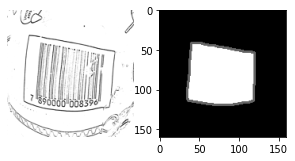

In [11]:
detector = Detector.load_from_checkpoint('/content/drive/MyDrive/MIPT/ocr/course_ocr/task3/d1.ckpt')
detector.eval()
detector = detector.to(device)

with torch.no_grad():
    imgs, filename, h, w = test_dataset[0]
    outputs = detector(imgs.unsqueeze(0).to(device))

if len(outputs[0]['masks']):
    mask = (outputs[0]['masks'][0].squeeze(0).detach().cpu().numpy() * 255).astype('uint8')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 12))
    ax1.imshow(imgs[0].detach().cpu().numpy(), cmap='gray')
    ax1.axis('off')

    _, mask = cv2.threshold(mask, 120, 255, cv2.THRESH_BINARY)
    cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    c = max(cnts, key=cv2.contourArea)
    cv2.drawContours(mask, [c], 0, (100,100,100), 2)
    ax2.imshow(mask, cmap='gray')
    plt.show()

In [12]:
ans = pd.DataFrame(columns=['name', 'code', 'x_0', 'y_0', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3'])
for i in tqdm(range(len(test_dataset))):
    with torch.no_grad():
        img, filename, h, w = test_dataset[i]
        outputs = detector(img.unsqueeze(0).to(device))

    if len(outputs[0]['masks']):
        mask = (outputs[0]['masks'][0].squeeze(0).detach().cpu().numpy() * 255).astype('uint8')
        _, mask = cv2.threshold(mask, 120, 255, cv2.THRESH_BINARY)
        cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        if len(cnts) > 0:
            c = max(cnts, key=cv2.contourArea)
            left = list(map(int, c[c[:, :, 0].argmin()][0] * [w / 160, h / 160]))
            right = list(map(int, c[c[:, :, 0].argmax()][0] * [w / 160, h / 160])) 
            top = list(map(int, c[c[:, :, 1].argmin()][0] * [w / 160, h / 160]))
            bot = list(map(int, c[c[:, :, 1].argmax()][0] * [w / 160, h / 160]))

        cur_row = {}
        cur_row['name'] = filename
        cur_row['code'] = 0
        cur_row['x_0'] = left[0]
        cur_row['y_0'] = left[1]
        cur_row['x_1'] = top[0]
        cur_row['y_1'] = top[1]
        cur_row['x_2'] = right[0]
        cur_row['y_2'] = right[1]
        cur_row['x_3'] = bot[0] 
        cur_row['y_3'] = bot[1] 
        ans = ans.append(cur_row, ignore_index=True)

  0%|          | 0/99 [00:00<?, ?it/s]

In [13]:
ans.to_csv('answer.csv', sep=',', header=False, index=False, encoding='utf-16')

In [14]:
markup_ans = read_file(os.path.join('/content/drive/MyDrive/MIPT/ocr/course_ocr/task3/', 'answer.csv'))

detection_iou = calculate_detection_result(markup_test, markup_ans)
print("detection_iou =", detection_iou)

detection_iou = 0.7575757575757576
